In [3]:
import pickle
import numpy as np
import random
import copy

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

import matplotlib.pyplot as plt
%matplotlib  inline

Learn diffrent representation of the text as embedings.
Train neural networks that can transform self learn embedings to the Stanford pre Trained emmbedings

In [4]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        anom = 0
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            vec = np.array(line[1:], dtype=np.float64)
            if vec.shape[0] == emb_dim:
                words.add(curr_word)
                word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            else:
                anom += 1
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    print(anom)
    return words_to_index, index_to_words, word_to_vec_map
emb_dim = 50


def read_my_glove_vecs(w2v_map):
    my_word_to_vec_map = pickle.load(open(w2v_map,"rb"))
    my_words = my_word_to_vec_map.keys()
    my_words_to_index = {}
    my_index_to_words = {}
    i = 1
    for w in sorted(my_words):
        my_words_to_index[w] = i
        my_index_to_words[i] = w
        i = i + 1
    return my_words_to_index, my_index_to_words, my_word_to_vec_map

In [5]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.twitter.27B/glove.twitter.27B.'+str(emb_dim)+'d.txt')

1


In [6]:
lem_word_to_index, lem_index_to_word, lem_word_to_vec_map = read_my_glove_vecs('w2v_lemas_map.p')

In [7]:
low_word_to_index, low_index_to_word, low_word_to_vec_map = read_my_glove_vecs('w2v_low_map.p')

In [8]:
def get_vectors(words, mapping_to_vec):
    return[mapping_to_vec[w] for w in words]
    
    
def find_common_words(dict_1, dict_2):
    """ return the intersection of two dictonary keys """
    return list(set(dict_1.keys()) & set(dict_2.keys()))


def train_test_valid_split(word_to_vec_map1, word_to_vec_map2, test_size):
    """ 
    Split to  learn transformation matrix from X to y
    word_to_vec_map1 - X
    word_to_vec_map2 - y
    """

    common_words = find_common_words(word_to_vec_map1, word_to_vec_map2)
    split_test = int(len(common_words)*test_size)
    random.shuffle(common_words)
    w_test = common_words[:split_test]
    w_train = common_words[split_test:]
    
    X_test = get_vectors(w_test, word_to_vec_map1)
    X_train = get_vectors(w_train, word_to_vec_map1)
    
    y_test = get_vectors(w_test, word_to_vec_map2)
    y_train = get_vectors(w_train, word_to_vec_map2)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


    

In [27]:
X_train, X_test, y_train, y_test =  train_test_valid_split(lem_word_to_vec_map, word_to_vec_map, 0.4)

In [17]:
print(y_test.shape[0]+y_train.shape[0])

28173


In [23]:
total_number_words = len(lem_word_to_vec_map)
present_number_words = y_test.shape[0]+y_train.shape[0]
absent_number_words = total_number_words - present_number_words
print("Presnte words:",present_number_words)
print("Presnte words:",absent_number_words)

Presnte words: 28173
Presnte words: 4293


In [10]:
def train_model(hiden_units):
    model = Sequential()
    model.add(Dense(hiden_units, input_dim=emb_dim, activation='sigmoid'))
    model.add(Dense(emb_dim, activation='sigmoid'))
    optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0)
    train_loss = model.evaluate(X_train, y_train)
    test_loss = model.evaluate(X_test, y_test)
    return float(train_loss), float(test_loss)

In [11]:
def train_model_linear_activation(hiden_units):
    model = Sequential()
    model.add(Dense(hiden_units, input_dim=emb_dim, activation='sigmoid'))
    model.add(Dense(emb_dim, activation='linear'))
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.fit(X_train, y_train, epochs=1000, batch_size=128, verbose=0)
    train_loss = model.evaluate(X_train, y_train)
    test_loss = model.evaluate(X_test, y_test)
    return float(train_loss), float(test_loss)

In [12]:
           
train_losses = []
test_losses = []
for h_units in range(6,150,10):
    train_loss, test_loss = train_model_linear_activation(h_units)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
h_units_used = list(range(6,150,10))   


Instructions for updating:
keep_dims is deprecated, use keepdims instead
11269/11269 [==============================] - 0s 30us/step


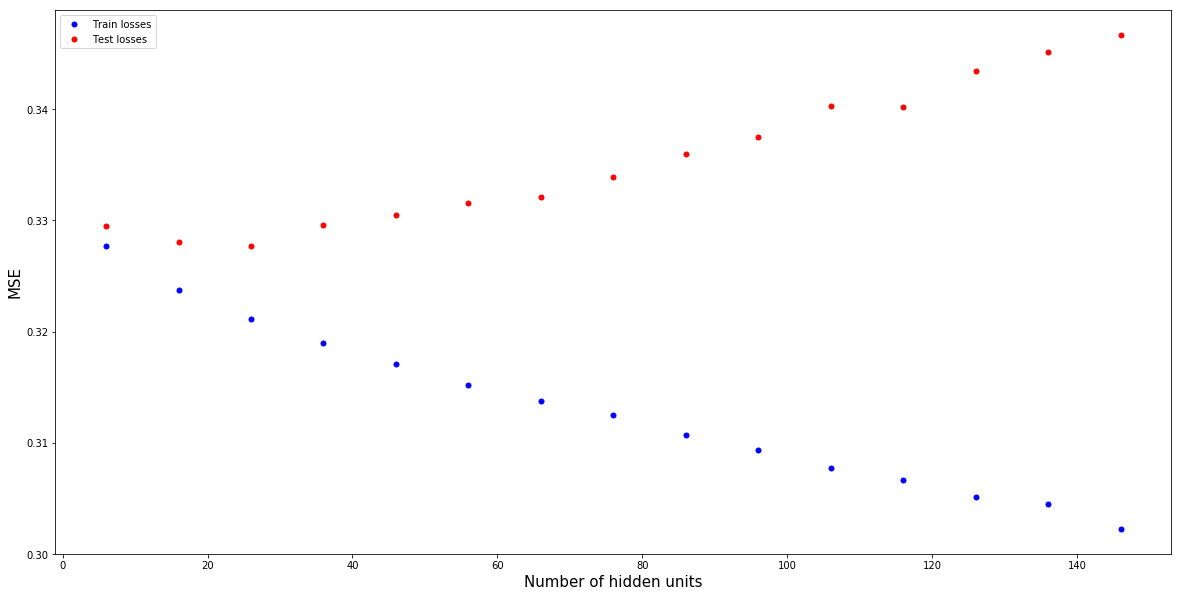

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(h_units_used, train_losses, 'b.', markersize=10, label='Train losses')
ax.plot(h_units_used, test_losses, 'r.',markersize=10, label='Test losses')
ax.set_xlabel(r'Number of hidden units', fontsize=15)
ax.set_ylabel(r'MSE', fontsize=15)
#ax.set_title('No activation',fontsize=20)
ax.legend()

In [ ]:
           
train_losses = []
test_losses = []
for h_units in range(6,151,10):
    train_loss, test_loss = train_model(h_units)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
h_units_used = list(range(6,151,10))   
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(h_units_used, train_losses, 'b.', markersize=10, label='Train losses')
ax.plot(h_units_used, test_losses, 'r.',markersize=10, label='Test losses')
ax.set_xlabel(r'Number of hidden units', fontsize=15)
ax.set_ylabel(r'MSE', fontsize=15)
ax.set_title('No activation',fontsize=20)

ax.legend()

0.8147236491700701
0.8120297969345739
11269/11269 [==============================] - 0s 35us/step


11269/11269 [==============================] - 0s 35us/step


11269/11269 [==============================] - 0s 33us/step


11269/11269 [==============================] - 0s 40us/step


11269/11269 [==============================] - 0s 28us/step


11269/11269 [==============================] - 0s 26us/step


11269/11269 [==============================] - 0s 25us/step


11269/11269 [==============================] - 0s 27us/step


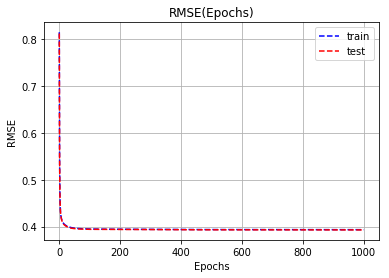

In [44]:
def train_neural_network():
    model = Sequential()
    model.add(Dense(6, input_dim=emb_dim, activation='sigmoid'))
    model.add(Dense(emb_dim, activation='sigmoid'))
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss="mean_squared_error", optimizer=opt)
    train_loss = mean_squared_error(X_train, y_train)
    test_loss = mean_squared_error(X_test, y_test)
    print(train_loss)
    print(test_loss)

    num_epochs = 1000
    train_aucs = [train_loss]
    test_aucs = [test_loss]
    for ep in range(1, num_epochs+1):
        model.fit(X_train, y_train, epochs=1, batch_size=128, verbose=0)
        train_loss = model.evaluate(X_train, y_train)
        test_loss = model.evaluate(X_test, y_test)
        train_aucs.append(train_loss)
        test_aucs.append(test_loss)

    fig, ax = plt.subplots()
    ax.plot(range(0,num_epochs+1), train_aucs, "b--", label="train")
    ax.plot(range(0,num_epochs+1), test_aucs, "r--", label="test")
    ax.set(xlabel='Epochs', ylabel='RMSE',
           title='RMSE(Epochs)')

    ax.legend()
    ax.grid()
train_neural_network()

In [24]:
X_train, X_test, y_train, y_test =  train_test_valid_split(low_word_to_vec_map, word_to_vec_map, 0.4)

In [26]:
total_number_words = len(low_word_to_vec_map)
present_number_words = y_test.shape[0]+y_train.shape[0]
absent_number_words = total_number_words - present_number_words
print("Presnte words:",present_number_words)
print("Presnte words:",absent_number_words)

Presnte words: 31180
Presnte words: 4316


In [60]:
train_losses = []
test_losses = []
for h_units in range(6,151,10):
    train_loss, test_loss = train_model(h_units)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
h_units_used = list(range(6,151,10))   

12472/12472 [==============================] - 1s 52us/step


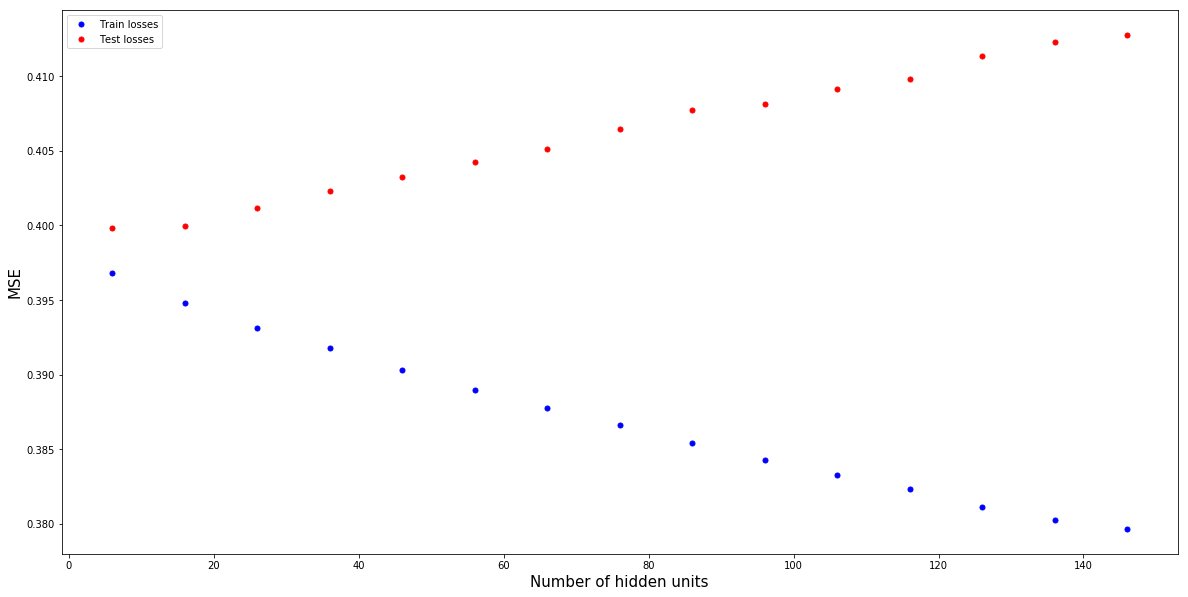

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(h_units_used, train_losses, 'b.', markersize=10, label='Train losses')
ax.plot(h_units_used, test_losses, 'r.',markersize=10, label='Test losses')
ax.set_xlabel(r'Number of hidden units', fontsize=15)
ax.set_ylabel(r'MSE', fontsize=15)
ax.legend()

In [39]:

def conv_to_vectors(word_to_vec_map1, word_to_vec_map2):
    """ 
    Split to  learn transformation matrix from X to y
    word_to_vec_map1 - X
    word_to_vec_map2 - y
    """

    common_words = find_common_words(word_to_vec_map1, word_to_vec_map2)
    random.shuffle(common_words)    
    X = get_vectors(common_words, word_to_vec_map1)    
    y = get_vectors(common_words, word_to_vec_map2)
    return np.array(X), np.array(y)
    
def train_final_model(hiden_units, X, y):
    model = Sequential()
    model.add(Dense(hiden_units, input_dim=emb_dim, activation='sigmoid'))
    model.add(Dense(emb_dim, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=1000, batch_size=128, verbose=0)
    return model

def train_final_model_non_linear(hiden_units, X, y):
    model = Sequential()
    model.add(Dense(hiden_units, input_dim=emb_dim, activation='sigmoid'))
    model.add(Dense(emb_dim, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=1000, batch_size=128, verbose=0)
    return model
def save_model(model, model_name="model"):
    model_json = model.to_json()
    with open(model_name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name+".h5")
def load_model(m_name):
    json_file = open(m_name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(m_name+".h5")

In [41]:
def add_to_old_glove_vect(word2vec_1, word2vec_2, model, dict_name):
    vectors = []
    words = []
    dict2 = copy.deepcopy(word2vec_2)
    for word in word2vec_1:
        if word not in dict2:
                vectors.append(word2vec_1[word])
                words.append(word)
    vectors = np.array(vectors)
    new_vecs = model.predict(vectors, batch_size=128,verbose=0)
    for i in range(len(words)):
        dict2[words[i]] = new_vecs[i]
    pickle.dump(dict2, open( dict_name+".p", "wb" ) )
    return dict2


In [11]:
def concat_glove_vect(word2vec_1, word2vec_2, dict_name):
    vectors = []
    words = []
    dict2 = copy.deepcopy(word2vec_2)
    for word in word2vec_1:
        if word not in word2vec_2:
            dict2[word] = word2vec_1[word]
            vectors.append(word2vec_1[word])
    pickle.dump(dict2, open( dict_name+".p", "wb" ) )
    return dict2

In [42]:
X, y = conv_to_vectors(lem_word_to_vec_map, word_to_vec_map)
model_lem_to_vec = train_final_model(6, X, y)
new_dict_lem = add_to_old_glove_vect(lem_word_to_vec_map, word_to_vec_map, model_lem_to_vec,"lemmas_and_normal_linear")

In [ ]:
X, y = conv_to_vectors(lem_word_to_vec_map, word_to_vec_map)
model_lem_to_vec = train_final_model_non_linear(6, X, y)
new_dict_lem = add_to_old_glove_vect(lem_word_to_vec_map, word_to_vec_map, model_lem_to_vec,"lemmas_and_normal")

In [14]:

concat_new_dict_lem = concat_glove_vect(lem_word_to_vec_map, word_to_vec_map,"concat_lemmas_and_normal")

In [43]:
X, y = conv_to_vectors(low_word_to_vec_map, word_to_vec_map)
model_lem_to_vec = train_final_model(6, X, y)
new_dict_low = add_to_old_glove_vect(low_word_to_vec_map, word_to_vec_map, model_lem_to_vec,"low_and_normal_linear")

In [16]:

new_dict_low = concat_glove_vect(low_word_to_vec_map, word_to_vec_map,"concat_low_and_normal")

In [ ]:
X, y = conv_to_vectors(low_word_to_vec_map, word_to_vec_map)
model_lem_to_vec = train_final_model_non_linear(6, X, y)
new_dict_low = add_to_old_glove_vect(low_word_to_vec_map, word_to_vec_map, model_lem_to_vec,"low_and_normal")